# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [27]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

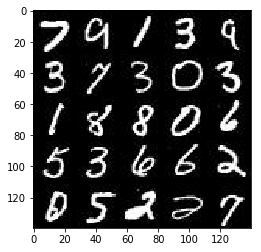

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

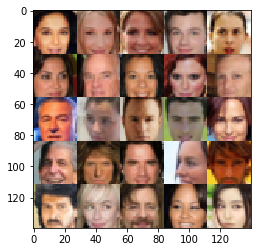

In [29]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum((.01 * x1), x1) # Alpha        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum((.01 * bn2), bn2)        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum((.01 * bn3), bn3)
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.reshape(tf.layers.dense(z, 7 * 7 * 512), (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum((.02*x1), x1)
        x2 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same"), training=is_train)
        x2 = tf.maximum((.02 * x2), x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum((.02 * x3), x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        output = tf.tanh(logits)
        
    return output    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model_gen = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model_gen, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    d_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                #  1++ == 0: bigger batch size?
                #  show_generator_output(x, x, x, x, x)    
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)                    
                           
            print("============= END OF EPOCH ==============")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.3041... Generator Loss: 0.7993
Epoch 1/2... Batch 20... Discriminator Loss: 0.8875... Generator Loss: 0.7962
Epoch 1/2... Batch 30... Discriminator Loss: 0.6924... Generator Loss: 1.0925
Epoch 1/2... Batch 40... Discriminator Loss: 0.8020... Generator Loss: 1.3743
Epoch 1/2... Batch 50... Discriminator Loss: 1.0647... Generator Loss: 0.9510
Epoch 1/2... Batch 60... Discriminator Loss: 0.9961... Generator Loss: 0.9603
Epoch 1/2... Batch 70... Discriminator Loss: 1.0448... Generator Loss: 1.6268
Epoch 1/2... Batch 80... Discriminator Loss: 1.0836... Generator Loss: 0.9071
Epoch 1/2... Batch 90... Discriminator Loss: 1.0842... Generator Loss: 0.6998
Epoch 1/2... Batch 100... Discriminator Loss: 1.4356... Generator Loss: 0.3696


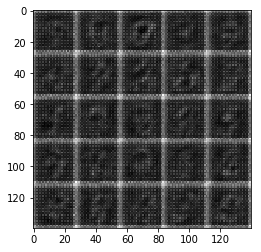

Epoch 1/2... Batch 110... Discriminator Loss: 1.1412... Generator Loss: 1.4487
Epoch 1/2... Batch 120... Discriminator Loss: 0.9749... Generator Loss: 1.1777
Epoch 1/2... Batch 130... Discriminator Loss: 1.0161... Generator Loss: 0.6666
Epoch 1/2... Batch 140... Discriminator Loss: 1.0380... Generator Loss: 1.5013
Epoch 1/2... Batch 150... Discriminator Loss: 1.1255... Generator Loss: 0.5319
Epoch 1/2... Batch 160... Discriminator Loss: 0.9254... Generator Loss: 1.4064
Epoch 1/2... Batch 170... Discriminator Loss: 0.9104... Generator Loss: 0.7522
Epoch 1/2... Batch 180... Discriminator Loss: 0.9989... Generator Loss: 1.8962
Epoch 1/2... Batch 190... Discriminator Loss: 0.7946... Generator Loss: 1.1897
Epoch 1/2... Batch 200... Discriminator Loss: 0.8060... Generator Loss: 1.7895


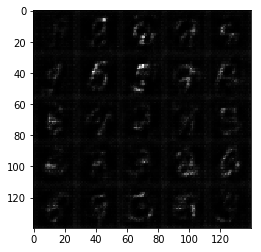

Epoch 1/2... Batch 210... Discriminator Loss: 0.6979... Generator Loss: 1.2472
Epoch 1/2... Batch 220... Discriminator Loss: 0.6843... Generator Loss: 1.1679
Epoch 1/2... Batch 230... Discriminator Loss: 0.7661... Generator Loss: 0.9815
Epoch 1/2... Batch 240... Discriminator Loss: 0.7682... Generator Loss: 0.9170
Epoch 1/2... Batch 250... Discriminator Loss: 0.7196... Generator Loss: 1.1177
Epoch 1/2... Batch 260... Discriminator Loss: 1.0209... Generator Loss: 0.6012
Epoch 1/2... Batch 270... Discriminator Loss: 0.6679... Generator Loss: 1.2686
Epoch 1/2... Batch 280... Discriminator Loss: 0.7737... Generator Loss: 1.8479
Epoch 1/2... Batch 290... Discriminator Loss: 0.6074... Generator Loss: 1.3235
Epoch 1/2... Batch 300... Discriminator Loss: 0.7963... Generator Loss: 2.1296


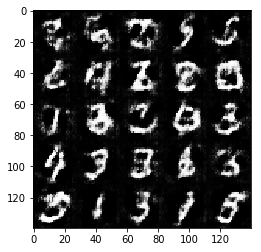

Epoch 1/2... Batch 310... Discriminator Loss: 0.7855... Generator Loss: 1.2567
Epoch 1/2... Batch 320... Discriminator Loss: 0.8444... Generator Loss: 1.4234
Epoch 1/2... Batch 330... Discriminator Loss: 0.8838... Generator Loss: 0.9772
Epoch 1/2... Batch 340... Discriminator Loss: 0.8064... Generator Loss: 0.9995
Epoch 1/2... Batch 350... Discriminator Loss: 1.4997... Generator Loss: 0.3371
Epoch 1/2... Batch 360... Discriminator Loss: 1.0511... Generator Loss: 1.7894
Epoch 1/2... Batch 370... Discriminator Loss: 0.8692... Generator Loss: 0.9286
Epoch 1/2... Batch 380... Discriminator Loss: 0.9274... Generator Loss: 1.0642
Epoch 1/2... Batch 390... Discriminator Loss: 0.9585... Generator Loss: 1.3500
Epoch 1/2... Batch 400... Discriminator Loss: 0.9016... Generator Loss: 0.8902


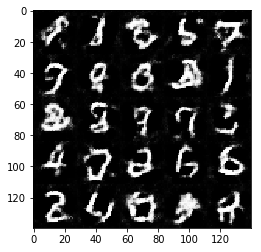

Epoch 1/2... Batch 410... Discriminator Loss: 1.0637... Generator Loss: 0.6092
Epoch 1/2... Batch 420... Discriminator Loss: 0.9572... Generator Loss: 0.9074
Epoch 1/2... Batch 430... Discriminator Loss: 1.2277... Generator Loss: 0.4990
Epoch 1/2... Batch 440... Discriminator Loss: 1.1828... Generator Loss: 0.5112
Epoch 1/2... Batch 450... Discriminator Loss: 0.9232... Generator Loss: 1.1468
Epoch 1/2... Batch 460... Discriminator Loss: 0.8146... Generator Loss: 1.2899
============= END OF EPOCH ==============
Epoch 2/2... Batch 470... Discriminator Loss: 1.4199... Generator Loss: 0.3758
Epoch 2/2... Batch 480... Discriminator Loss: 0.8914... Generator Loss: 1.0269
Epoch 2/2... Batch 490... Discriminator Loss: 0.8980... Generator Loss: 1.0150
Epoch 2/2... Batch 500... Discriminator Loss: 1.3804... Generator Loss: 0.3792


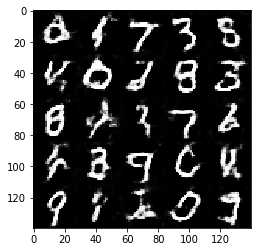

Epoch 2/2... Batch 510... Discriminator Loss: 0.9065... Generator Loss: 0.9886
Epoch 2/2... Batch 520... Discriminator Loss: 0.9160... Generator Loss: 1.0019
Epoch 2/2... Batch 530... Discriminator Loss: 1.0676... Generator Loss: 0.6142
Epoch 2/2... Batch 540... Discriminator Loss: 0.8220... Generator Loss: 1.2235
Epoch 2/2... Batch 550... Discriminator Loss: 1.0583... Generator Loss: 0.6310
Epoch 2/2... Batch 560... Discriminator Loss: 0.8908... Generator Loss: 0.9926
Epoch 2/2... Batch 570... Discriminator Loss: 0.8300... Generator Loss: 1.3360
Epoch 2/2... Batch 580... Discriminator Loss: 0.9019... Generator Loss: 1.0021
Epoch 2/2... Batch 590... Discriminator Loss: 1.0071... Generator Loss: 1.0461
Epoch 2/2... Batch 600... Discriminator Loss: 1.1585... Generator Loss: 2.0156


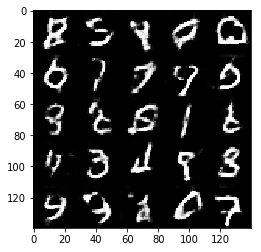

Epoch 2/2... Batch 610... Discriminator Loss: 1.0599... Generator Loss: 0.6650
Epoch 2/2... Batch 620... Discriminator Loss: 1.1011... Generator Loss: 0.5906
Epoch 2/2... Batch 630... Discriminator Loss: 0.9828... Generator Loss: 0.8831
Epoch 2/2... Batch 640... Discriminator Loss: 0.8979... Generator Loss: 1.1989
Epoch 2/2... Batch 650... Discriminator Loss: 0.8743... Generator Loss: 0.9332
Epoch 2/2... Batch 660... Discriminator Loss: 0.9948... Generator Loss: 1.9208
Epoch 2/2... Batch 670... Discriminator Loss: 0.9974... Generator Loss: 0.7190
Epoch 2/2... Batch 680... Discriminator Loss: 0.9089... Generator Loss: 0.9491
Epoch 2/2... Batch 690... Discriminator Loss: 0.9068... Generator Loss: 1.1828
Epoch 2/2... Batch 700... Discriminator Loss: 0.9587... Generator Loss: 0.8398


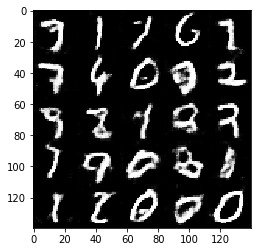

Epoch 2/2... Batch 710... Discriminator Loss: 0.8782... Generator Loss: 0.8302
Epoch 2/2... Batch 720... Discriminator Loss: 0.8879... Generator Loss: 1.4174
Epoch 2/2... Batch 730... Discriminator Loss: 0.8566... Generator Loss: 1.3594
Epoch 2/2... Batch 740... Discriminator Loss: 0.8915... Generator Loss: 1.5152
Epoch 2/2... Batch 750... Discriminator Loss: 0.8868... Generator Loss: 1.1775
Epoch 2/2... Batch 760... Discriminator Loss: 0.8874... Generator Loss: 1.0761
Epoch 2/2... Batch 770... Discriminator Loss: 1.0659... Generator Loss: 0.6694
Epoch 2/2... Batch 780... Discriminator Loss: 0.9528... Generator Loss: 0.8493
Epoch 2/2... Batch 790... Discriminator Loss: 0.9085... Generator Loss: 0.9744
Epoch 2/2... Batch 800... Discriminator Loss: 0.9215... Generator Loss: 0.7489


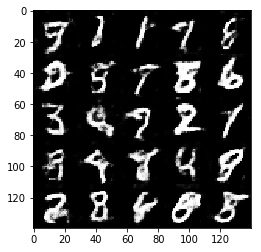

Epoch 2/2... Batch 810... Discriminator Loss: 0.8791... Generator Loss: 1.2870
Epoch 2/2... Batch 820... Discriminator Loss: 0.9896... Generator Loss: 1.6454
Epoch 2/2... Batch 830... Discriminator Loss: 0.8245... Generator Loss: 1.2074
Epoch 2/2... Batch 840... Discriminator Loss: 0.8580... Generator Loss: 1.3010
Epoch 2/2... Batch 850... Discriminator Loss: 0.8887... Generator Loss: 1.0882
Epoch 2/2... Batch 860... Discriminator Loss: 0.8970... Generator Loss: 0.9631
Epoch 2/2... Batch 870... Discriminator Loss: 1.2043... Generator Loss: 0.4846
Epoch 2/2... Batch 880... Discriminator Loss: 0.8395... Generator Loss: 1.5388
Epoch 2/2... Batch 890... Discriminator Loss: 1.1023... Generator Loss: 0.5785
Epoch 2/2... Batch 900... Discriminator Loss: 0.9483... Generator Loss: 1.6081


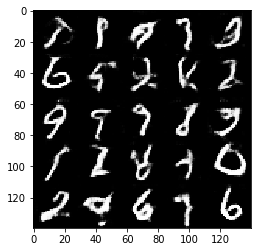

Epoch 2/2... Batch 910... Discriminator Loss: 0.9064... Generator Loss: 0.8322
Epoch 2/2... Batch 920... Discriminator Loss: 0.7976... Generator Loss: 1.5062
Epoch 2/2... Batch 930... Discriminator Loss: 0.9215... Generator Loss: 0.7965
============= END OF EPOCH ==============


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.7454... Generator Loss: 1.0243
Epoch 1/1... Batch 20... Discriminator Loss: 0.4825... Generator Loss: 1.4668
Epoch 1/1... Batch 30... Discriminator Loss: 0.4396... Generator Loss: 1.7549
Epoch 1/1... Batch 40... Discriminator Loss: 0.4898... Generator Loss: 1.4881
Epoch 1/1... Batch 50... Discriminator Loss: 0.3060... Generator Loss: 2.3272
Epoch 1/1... Batch 60... Discriminator Loss: 0.5484... Generator Loss: 1.5169
Epoch 1/1... Batch 70... Discriminator Loss: 0.6336... Generator Loss: 1.5992
Epoch 1/1... Batch 80... Discriminator Loss: 0.7968... Generator Loss: 1.5647
Epoch 1/1... Batch 90... Discriminator Loss: 0.6004... Generator Loss: 1.1749
Epoch 1/1... Batch 100... Discriminator Loss: 0.4953... Generator Loss: 2.1465


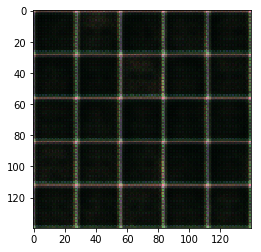

Epoch 1/1... Batch 110... Discriminator Loss: 0.4682... Generator Loss: 2.2251
Epoch 1/1... Batch 120... Discriminator Loss: 0.4685... Generator Loss: 1.7965
Epoch 1/1... Batch 130... Discriminator Loss: 0.7460... Generator Loss: 1.6997
Epoch 1/1... Batch 140... Discriminator Loss: 1.0801... Generator Loss: 0.5920
Epoch 1/1... Batch 150... Discriminator Loss: 0.4368... Generator Loss: 1.8445
Epoch 1/1... Batch 160... Discriminator Loss: 0.9717... Generator Loss: 0.7376
Epoch 1/1... Batch 170... Discriminator Loss: 0.8821... Generator Loss: 0.8200
Epoch 1/1... Batch 180... Discriminator Loss: 0.6280... Generator Loss: 4.5765
Epoch 1/1... Batch 200... Discriminator Loss: 1.1050... Generator Loss: 4.4639


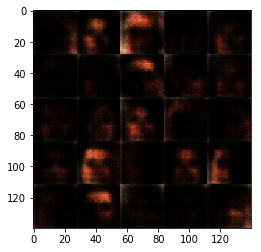

Epoch 1/1... Batch 210... Discriminator Loss: 0.8412... Generator Loss: 0.9097
Epoch 1/1... Batch 220... Discriminator Loss: 0.6957... Generator Loss: 1.1688
Epoch 1/1... Batch 230... Discriminator Loss: 0.4852... Generator Loss: 1.7085
Epoch 1/1... Batch 240... Discriminator Loss: 0.6062... Generator Loss: 1.0648
Epoch 1/1... Batch 250... Discriminator Loss: 0.3175... Generator Loss: 2.2270
Epoch 1/1... Batch 260... Discriminator Loss: 1.2410... Generator Loss: 0.4945
Epoch 1/1... Batch 270... Discriminator Loss: 0.3226... Generator Loss: 3.8922
Epoch 1/1... Batch 280... Discriminator Loss: 0.4366... Generator Loss: 1.6342
Epoch 1/1... Batch 290... Discriminator Loss: 0.3705... Generator Loss: 2.3535
Epoch 1/1... Batch 300... Discriminator Loss: 0.3543... Generator Loss: 3.5399


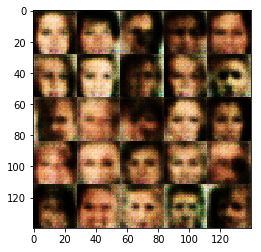

Epoch 1/1... Batch 310... Discriminator Loss: 0.4303... Generator Loss: 1.6204
Epoch 1/1... Batch 320... Discriminator Loss: 1.7258... Generator Loss: 0.2524
Epoch 1/1... Batch 330... Discriminator Loss: 0.3176... Generator Loss: 1.9043
Epoch 1/1... Batch 340... Discriminator Loss: 0.6242... Generator Loss: 1.1471
Epoch 1/1... Batch 350... Discriminator Loss: 0.2462... Generator Loss: 2.5908
Epoch 1/1... Batch 360... Discriminator Loss: 0.3739... Generator Loss: 4.8438
Epoch 1/1... Batch 370... Discriminator Loss: 0.2564... Generator Loss: 3.3919
Epoch 1/1... Batch 380... Discriminator Loss: 0.2227... Generator Loss: 2.2604
Epoch 1/1... Batch 390... Discriminator Loss: 0.7962... Generator Loss: 0.8194
Epoch 1/1... Batch 400... Discriminator Loss: 0.3080... Generator Loss: 3.4178


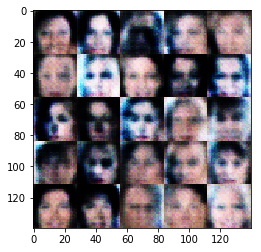

Epoch 1/1... Batch 410... Discriminator Loss: 0.4418... Generator Loss: 3.1860
Epoch 1/1... Batch 420... Discriminator Loss: 0.1643... Generator Loss: 3.8611
Epoch 1/1... Batch 430... Discriminator Loss: 0.3619... Generator Loss: 1.6048
Epoch 1/1... Batch 440... Discriminator Loss: 0.1188... Generator Loss: 3.5775


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.